# Armory-Library Tutorial

In this tutorial, we will demonstrate how to run an example in armory-library
with an example model and dataset. In this tutorial we will use the mnist
dataset for simplicity and a model via HuggingFace that was pre-trained on the
mnist dataset.

## Package Installs

In addition to the `armory-library` package, we install the `datasets` package
because we will use it later to retrieve a dataset from the HuggingFace hub. 

In [ ]:
!pip install armory-library
!pip install datasets

## Imports

These are all the necessary imports to run the example file and will all be used and explained later in the notebook.

In [ ]:
import json
from pprint import pprint

from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
import datasets
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import torch
import torch.nn
import torchmetrics.classification
from transformers import AutoImageProcessor, AutoModelForImageClassification

from armory.data import DataType, ImageDimensions, Images, Scale
from armory.dataset import ImageClassificationDataLoader
from armory.engine import EvaluationEngine
import armory.evaluation as ev
from armory.export.criteria import every_n_batches
from armory.export.image_classification import ImageClassificationExporter
from armory.metric import PerturbationMetric, PredictionMetric
from armory.metrics.compute import BasicProfiler
from armory.metrics.perturbation import PerturbationNormMetric
from armory.model.image_classification import ImageClassifier
from armory.perturbation import ArtEvasionAttack
from armory.track import track_init_params, track_params

2024-03-13 15:20:15.810615: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 15:20:15.859816: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 15:20:15.859843: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 15:20:15.859877: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 15:20:15.869886: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

In [ ]:
batch_size = 8
num_batches = 10

We define some runtime parameters here. These can be overwritten externally
via papermill (e.g., `-p batch_size 4`). Modify these as necessary based on your
host resource constraints.

## Loading and Wrapping the Dataset

In [ ]:
hf_dataset = datasets.load_dataset("mnist", split="test")

We load the dataset from the HuggingFace hub. The "mnist" dataset is the same
one used to pre-train our selected model.

Since we are only performing an evaluation of the already-trained model, we only
load the "test" split.

In [ ]:
labels = hf_dataset.features["label"].names
labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

We obtain the labels from the features of the dataset.

In [ ]:
hf_processor = AutoImageProcessor.from_pretrained(
    "farleyknight-org-username/vit-base-mnist"
)
hf_processor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Here we load a pre-configured image processor from HuggingFace for our selected
model. This processor ensures that images from the dataset will be formatted
correctly when used as inputs to the model.

By printing the processor to the console or by visually inspecting the
`preprocessor_config.json` file on HuggingFace for the selected model, we can
see that this image processor will:
- Resize images to 224x224.
- Normalize the image data using a mean of `(0.5, 0.5, 0.5)` and a standard
  deviation of `(0.5, 0.5, 0.5)`.

In [ ]:
image_mean = tuple(hf_processor.image_mean)
image_std = tuple(hf_processor.image_std)

image_height = hf_processor.size["height"]
image_width = hf_processor.size["width"]

image_min = 0.0 - max(image_mean) / min(image_std)
image_max = 1.0 - min(image_mean) / min(image_std)

We'll save these parameters from the processor so we can use them later.

We can calculate the minimum and maximum normalized values by taking the
unnormalized min and max (0.0 and 1.0) and applying the normalization equation
using the image processor's mean and standard deviation.

Although unnecessary in this case because the mean and standard deviation is the
same across all three channels, we demonstrate here the calculation using the
largest or smallest values as though each channel had different values (e.g.,
when using the ImageNet normalization values). We use the largest mean value
when calculating the min so we get the lowest negative number possible. But we
use the smallest mean value when calculating the max so we get the highest
positive number possible. We use the smallest standard deviation value in both
cases in the denominator to get the highest and lowest numbers possible.

In [ ]:
def transform(sample):
    sample["image"] = hf_processor([img.convert("RGB") for img in sample["image"]])[
        "pixel_values"
    ]
    return sample

hf_dataset.set_transform(transform)

We write a transform function that will be applied to the dataset. This
transform will convert images to RGB color mode (in case they aren't already)
and then pass them through the pre-configured HuggingFace image processor.

In [ ]:
dataloader = ImageClassificationDataLoader(
    hf_dataset,
    dim=ImageDimensions.CHW,
    scale=Scale(
        dtype=DataType.FLOAT,
        max=1.0,
        mean=image_mean,
        std=image_std,
    ),
    image_key="image",
    label_key="label",
    batch_size=batch_size,
)

Lastly we create a data loader for the dataset. As the data loader is
responsible for creating the self-describing, structured batches of data, it
is objective-specific (i.e., image classification vs object detection) and must
be informed about characteristics of the samples coming out of the dataset (and
any transforms that have been applied).

In our case, we instruct the data loader that the images from the dataset will
have a channels-first dimensionality and have been normalized to a particular
mean and standard deviation. When unnormalized, the data is floating point
values ranging from 0 to 1.0. The `image_key` and `label_key` are the property
names in the sample dictionaries out of the dataset containing the image data
and target labels, respectively.

## Loading and Wrapping the Model

In [ ]:
hf_model = track_params(AutoModelForImageClassification.from_pretrained)(
    pretrained_model_name_or_path="farleyknight-org-username/vit-base-mnist"
)

We load a pre-trained model found on HuggingFace that has been trained on the
mnist dataset with the model card `farleyknight-org-username/vit-base-mnist`.
This can be replaced with another model off of Huggingface or you can use a
custom local model.

We use the `track_params` function decorator to automatically record keyword
arguments as parameters in MLFlow.

In [ ]:
model = ImageClassifier(
    name="ViT",
    model=hf_model,
    accessor=Images.as_torch(),
)

We must wrap the HuggingFace model in order to make it compatible with Armory.
This is because Armory uses a self-describing, structured data type for model
inputs. The `ImageClassifier` class is a generic wrapper around Torch-like image
classification models.

To instruct the wrapper how the model inputs should be extracted from the Armory
inputs, we specify an "accessor" instance. An accessor is a pre-configured means
to convert between a self-describing, structured Armory data type (such as
`Images`) and an unustructured data type (such as a Torch `Tensor`).

In [ ]:
art_classifier = track_init_params(PyTorchClassifier)(
    model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.003),
    input_shape=(3, image_height, image_width),
    channels_first=True,
    nb_classes=len(labels),
    clip_values=(image_min, image_max),
)

Lastly we wrap the model in an ART estimator in order to make the model
compatible with attacks and defences from the Adversarial Robustness Toolbox
(ART).

Like the `track_params` function decorator, the `track_init_params` decorator
works on classes to track keyword arguments to the init method.

Here we use the image size, min/max values, and label information we obtained
from the image processor and dataset. When not using a HuggingFace model or if
you chose not to introspect the image processor, you must take care that the
`input_shape`, `channels_first`, and `clip_values` parameters match the input
requirements of the model. Similarly, the `nb_classes` parameter must match the
number of output classes supported by the classification model.

## Configure the Attack

In [ ]:
art_pgd = track_init_params(ProjectedGradientDescent)(
    art_classifier,
    batch_size=batch_size,
    eps=8/255/min(image_std),
    eps_step=1/255/min(image_std),
    max_iter=20,
    num_random_init=1,
    random_eps=False,
    targeted=False,
    verbose=False,
)

We use the projected gradient descent (PGD) attack from ART (see
https://arxiv.org/abs/1706.06083 for more info). Again, we use the
`track_init_params` decorator to have the parameters of the attack recorded.
This is particularly useful when tweaking the parameters of the attack, as the
input attack parameters and the resulting outputs from the model can be easily
compared and analyzed in MLFlow.

In [ ]:
attack = ArtEvasionAttack(
    name="PGD",
    attack=art_pgd,
    use_label_for_untargeted=True,
    inputs_accessor=Images.as_numpy(),
)

In a similar fashion to the model, we must wrap the ART attack in order to make
it compatible with Armory. This wrapper is specific to ART evasion attacks and
will handle:
- converting the self-describing, structured data (using accessors)
- generating the target labels for the attack when the attack is a targeted
  attack
- replacing the inputs in the current batch with the outputs of the attack

Use specify `use_label_for_untargeted=True` because our attack is not targeted
and we want to use the natural labels as the `y` parameter to the ART attack's
`generate` method (i.e. "misclassify to anything but the natural label").

Unlike our model wrapper, which used an `Images.as_torch()` accessor, here we
use a `Images.as_numpy()` accessor since ART attacks accept NumPy array inputs
rather than Torch tensors.

## Define the Metrics

In [ ]:
linf_norm = PerturbationMetric(
    PerturbationNormMetric(ord=torch.inf),
)

A perturbation metric is a metric derived from the initial, unperturbed inputs
and the final, perturbed inputs in each batch. The `PerturbationMetric` wrapper
handles converting the current batch's inputs from self-describing, structured
data using accessors. Here we use the default `as_torch` accessor.

The `PerturbationNormMetric` is an L-norm measurement of the difference between
the initial and the perturbed data. In this case, we are calculating the
L-infinity norm, which is the largest magnitude of difference for any particular
pixel in the image. Other supported norms are L0, L1, and L2 (using `ord=0`,
`ord=1`, and `ord=2` respectively).

In [ ]:
accuracy = PredictionMetric(
    torchmetrics.classification.Accuracy(
        task="multiclass", num_classes=len(labels)
    ),
)

A prediction metric is a metric derived from the natural targets and the output
predictions of the model for each batch. The `PredictionMetric` wrapper handles
converting the current batch's target labels and predicted labels from
self-describing, structured data using accessors. Here we use the default
`as_torch` accessor.

We use the `Accuracy` metric provided by `torchmetrics`. Any of the
classification metrics from `torchmetrics` can be used here.

## Define the Exporters

In [ ]:
exporter = ImageClassificationExporter(criteria=every_n_batches(num_batches))

We use the `ImageClassificationExporter` to have image samples properly exported
as image files.

By using the `every_n_batches` criteria with the number of batches being
evaluated, we will effectively export only the last batch. There are a variety
of criteria implementations available in the `armory.export.criteria` module.

## Running the Evaluation

In [ ]:
evaluation = ev.Evaluation(
    name="mnist-vit-pgd",
    description="MNIST image classification using a ViT model and PGD attack",
    author="TwoSix",
    dataset=ev.Dataset(
        name="MNIST",
        dataloader=dataloader,
    ),
    model=model,
    perturbations={
        "benign": [],
        "attack": [attack],
    },
    metrics={
        "linf_norm": linf_norm,
        "accuracy": accuracy,
    },
    exporters=[exporter],
    profiler=BasicProfiler(),
)

Here we define the final configuration of the evaluation, which includes the
model, dataset, attack, and metrics that we created earlier.

We define two perturbation chains, "benign" and "attack". As each batch is
evaluated, Armory will pass the batch through each chain and record metrics for
each chain independently.

The `BasicProfiler` enables computation-time profiling on various stages of the
Armory evaluation.

In [ ]:
engine = EvaluationEngine(
    evaluation,
    limit_test_batches=num_batches,
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


Lastly, we create an instance of the Armory evaluation engine. We are going to
evaluate a subset of the dataset as specified by the `limit_test_batches`
parameter.

In [ ]:
results = engine.run()
pprint(results)

2024/03/13 15:20:35 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kyle-treubig/Code/jatic/armory/.venv-3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      attack/accuracy      │            0.0            │
│     attack/linf_norm      │     0.062745101749897     │
│      benign/accuracy      │            1.0            │
│     benign/linf_norm      │            0.0            │
└───────────────────────────┴───────────────────────────┘

2024/03/13 15:23:39 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/03/13 15:23:39 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


{'compute': {'Avg. CPU time (s) for 10 executions of attack/perturbation': 17.455582508399676,
             'Avg. CPU time (s) for 10 executions of attack/perturbation/PGD': 17.455571591099577,
             'Avg. CPU time (s) for 10 executions of attack/predict': 0.011246485199808375,
             'Avg. CPU time (s) for 10 executions of benign/perturbation': 1.4613993698731066e-06,
             'Avg. CPU time (s) for 10 executions of benign/predict': 0.09405028139990464},
 'metrics': {'attack/accuracy': tensor(0.),
             'attack/linf_norm': tensor(0.0627),
             'benign/accuracy': tensor(1.),
             'benign/linf_norm': tensor(0.)}}


The following block of code displays a few samples of images and their
predictions from the Armory evaluation run. We obtain the artifact directory
path from MLFlow.

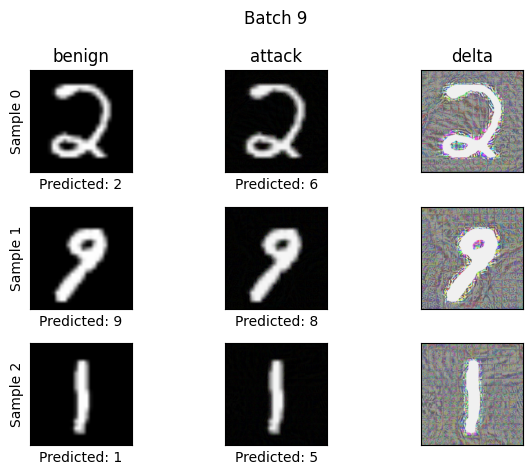

In [ ]:
def get_predicted_label(filepath):
    with open(filepath, "r") as infile:
        data = json.load(infile)
        return np.argmax(data["predictions"])


# strip off the initial 'file://' prefix
artifact_uri = mlflow.get_run(engine.run_id).info.artifact_uri[7:]

batch_idx = num_batches - 1
num_samples = min(3, batch_size)

fig, axes = plt.subplots(nrows=num_samples, ncols=3)

for sample_idx in range(num_samples):
    benign_image = plt.imread(f"{artifact_uri}/batch_{batch_idx}_ex_{sample_idx}_benign.png")
    benign_label = get_predicted_label(f"{artifact_uri}/batch_{batch_idx}_ex_{sample_idx}_benign.txt")
    attack_image = plt.imread(f"{artifact_uri}/batch_{batch_idx}_ex_{sample_idx}_attack.png")
    attack_label = get_predicted_label(f"{artifact_uri}/batch_{batch_idx}_ex_{sample_idx}_attack.txt")

    # shift by eps so the delta has a min of 0, then multiply by 10 to make the diff more pronounced
    delta_image = ((benign_image - attack_image) + art_pgd.eps) * 10

    if sample_idx == 0:
        axes[sample_idx][0].set_title("benign")
        axes[sample_idx][1].set_title("attack")
        axes[sample_idx][2].set_title("delta")

    axes[sample_idx][0].set_ylabel(f"Sample {sample_idx}")

    axes[sample_idx][0].imshow(benign_image)
    axes[sample_idx][0].set_xlabel(f"Predicted: {benign_label}")

    axes[sample_idx][1].imshow(attack_image)
    axes[sample_idx][1].set_xlabel(f"Predicted: {attack_label}")

    axes[sample_idx][2].imshow(delta_image)

    for col in range(3):
        axes[sample_idx][col].tick_params(
            bottom=False, left=False, labelbottom=False, labelleft=False
        )

fig.suptitle(f"Batch {batch_idx}")
fig.tight_layout()